### Overview:

* Used the reddit API to get 7000+ comments from 7 of the most famous self help subreddits
* Trying to figure out how we talk about a variety of self help topics
* What words do we use while referring to certain topics?
* Which topics do we focus on the most?
* What are the most common pain points for us?
* How often do we talk about certain topics?

### Challnges:

* None of the data is labelled according to topics, the subreddits don't really divide according to topic
* Data wasn't cleaned initially, but that has been handled in basic.py
* How do we handle misspelled words?
    * for this I'm going on the underlying assumption that no one would make the same exact spelling mistake more than 3 times and am choosing to ignore those words that show up in the document less than thrice

### How are we going to do this?

* Topic modeling
    * LDA
    
* Clustering
    * Word embeddings using word2vec to show similarity between certain words


In [237]:
import pandas as pd 
import numpy as np
import re
import sys 

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib notebook
from ipywidgets import *

from nltk.corpus import stopwords
from nltk import word_tokenize 
from nltk.cluster import KMeansClusterer
import nltk
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

import gensim
from gensim import corpora, models
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS


from sklearn.cluster import KMeans;
from sklearn.neighbors import KDTree;

import warnings
warnings.filterwarnings('ignore')



In [64]:
df = pd.read_csv("final_data.csv")
df.head()

,Unnamed: 0,Unnamed: 0.1,id,body,self,orig,score,author,title,time,subreddit_name,body_length,title_length,category
0,0,0.0,hr3zny,Seriously guys. I hate seeing this shit. I und...,True,False,5324,St31nway,"For every upvote I get, I will read 500 pages,...",2020-7,selfimprovement,74.0,18.0,NaN
1,1,1.0,g6vmn5,\n\n**Everything is Temporary:** \n\nWhen I w...,True,False,3443,Reinvention_Coach,5 Lessons I Learned In Prison to Help You With...,2020-4,selfimprovement,347.0,11.0,NaN
2,2,2.0,igbob8,# 5. “Too late” is not exists\n\nIn my early 2...,True,False,2380,fromzerototop1,5 Life Lessons I Wish I’d Known At the Early 20s,2020-8,selfimprovement,365.0,11.0,NaN
3,3,3.0,bsvrq2,I attempted suicide at 13 and began the journe...,True,False,2302,eatmenlikeair,"When I attempted suicide at 13, I promised mys...",2019-5,selfimprovement,849.0,22.0,NaN
4,4,4.0,ilcix7,**My interpretation**: A common and natural ex...,True,False,2103,Sbeast,"""He who blames others has a long way to go on ...",2020-9,selfimprovement,98.0,30.0,NaN


In [65]:
def clean_text(df):
    '''
    Clean the body and title cols in the dataframe to get rid of:
    1. Stopwords
    2. Special Symbols - not inclusive of numbers
    3. Convert to lower case
    '''

    REPLACE_BY_SPACE = re.compile('[/()\{\}\[\][\|@,;*\#\+\?\=\-\:\.\&]')
    STOPWORDS =re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b')

    df['body']=df['body'].str.lower()
    df['title']=df['title'].str.lower()
    df['body']=df['body'].str.replace(STOPWORDS, '')
    df['body']=df['body'].str.replace('x200b', '')
    df['body']=df['body'].str.replace('"', '')
    df['body']=df['body'].str.replace("'", '')
    df['body']=df['body'].str.replace("\n", '')
    df['body']=df['body'].str.replace("!", '')
    df['body']=df['body'].str.replace('“','')
    df['body']=df['body'].str.replace('’','')
    df['body']=df['body'].str.replace(REPLACE_BY_SPACE, '')
    
    df['title']=df['title'].str.replace('’','')
    df['title']=df['title'].str.replace('"', '')
    df['title']=df['title'].str.replace("'", '')
    df['title']=df['title'].str.replace("!", '')
    df['title']=df['title'].str.replace('“','')
    df['title']=df['title'].str.replace("\n", '')
    df['title']=df['title'].str.replace(STOPWORDS, '')
    df['title']=df['title'].str.replace(REPLACE_BY_SPACE, '')
    df['title']=df['title'].str.replace('x200b', ' ')
    df.body = df.body.replace('\s+', ' ', regex=True)
    df.title = df.title.replace('\s+', ' ', regex=True)

    return df

In [66]:
df= clean_text(df)
df= df.drop(df.iloc[:,0:2], axis=1)
df.head()

,id,body,self,orig,score,author,title,time,subreddit_name,body_length,title_length,category
0,hr3zny,seriously guys hate seeing shit understand app...,True,False,5324,St31nway,every upvote get read 500 pages 25 pushups st...,2020-7,selfimprovement,74.0,18.0,NaN
1,g6vmn5,everything temporary prison felt like would f...,True,False,3443,Reinvention_Coach,5 lessons learned prison help quarantine,2020-4,selfimprovement,347.0,11.0,NaN
2,igbob8,5 “ late” exists early 20s compared others co...,True,False,2380,fromzerototop1,5 life lessons wish ’ known early 20s,2020-8,selfimprovement,365.0,11.0,NaN
3,bsvrq2,attempted suicide 13 began journey emotional ...,True,False,2302,eatmenlikeair,attempted suicide 13 promised 33 ’ life worse...,2019-5,selfimprovement,849.0,22.0,NaN
4,ilcix7,interpretation common natural experience life...,True,False,2103,Sbeast,blames others long way go journey blames half...,2020-9,selfimprovement,98.0,30.0,NaN


In [67]:
df = df[df['category'].isna()]

### Fixing NaN
* Let the id be for now
* Body being NaN just means the most came without a body, just a title. So just change that to an empty string.
* Self - change to False if body is an empty string, else True.
* Orig is False
* Change author to Unknown
* Time leave as is 
* Change body_length to length of body
* Change title_length to length of title


In [68]:
df.isna().sum()

id                 133
body              3239
self               133
orig               133
score                0
author             640
title                0
time               133
subreddit_name       0
body_length        133
title_length       133
category          7058
dtype: int64

In [74]:
fill_values={'body':'','orig':False,'author':'Unknown'}
df = df.fillna(value = fill_values)

df.self[(df['body']=='') & (df['self'].isna())] = False
df = df.fillna(value = {'self':True})

df.body_length[(df['body']=='') & (df['body_length'].isna())] = 0.0
df.body_length[(df['body']!='') & (df['body_length'].isna())] = df['body'].str.len()

df.title_length[(df['title']=='') & (df['title_length'].isna())] = 0.0
df.title_length[(df['title']!='') & (df['title_length'].isna())] = df['title'].str.len()

print(df.isna().sum())

id                 133
body                 0
self                 0
orig                 0
score                0
author               0
title                0
time               133
subreddit_name       0
body_length          0
title_length         0
category          7058
dtype: int64


## LDA TOPIC MODELING

In [246]:
def lemmatize_stemming(words):
    lemmatizer = WordNetLemmatizer()
    for i in range(len(words)):
        words[i]= lemmatizer.lemmatize(words[i])
    return words
    

def port_stemming(words):
    porter_stemmer = PorterStemmer()
    for i in range(len(words)):
        words[i] = porter_stemmer.stem(words[i])
    return words

In [268]:
df_new = df['title'].str.cat(df['body'],sep =" ")
df_new= df_new.str.replace('“','')
df_new= df_new.str.replace('”','')
df_new = df_new.str.replace("’",'')
df_tok = pd.DataFrame(df_new)
df_new =list(df_new)
docs=[]
for i in df_new:
    docs.append(i.split( ))
    
print(docs[:10])

[['every', 'upvote', 'get', 'read', '500', 'pages', '25', 'pushups', 'study', '5', 'hours', 'seriously', 'guys', 'hate', 'seeing', 'shit', 'understand', 'appreciate', 'want', 'get', 'better', 'relying', 'random', 'strangers', 'online', 'something', 'never', 'going', 'work', 'way', 'get', 'something', 'done', 'develop', 'discipline', 'comes', 'stop', 'asking', 'upvotes', 'help', 'help', 'get', 'inspiration', 'others', 'journey', 'self', 'improvement', 'stop', 'relying', 'numbers', 'motivate'], ['5', 'lessons', 'learned', 'prison', 'help', 'quarantine', 'everything', 'temporary', 'prison', 'felt', 'like', 'would', 'forever', 'permanent', 'state', 'uncertainty', 'pain', 'felt', 'though', 'would', 'worthless', 'remainder', 'life', 'looked', 'beyond', 'fear', 'anxiety', 'understood', 'expiration', 'date', 'know', 'knew', 'one', 'alone', 'gave', 'strength', 'endure', 'power', 'impermanence', 'perspective', 'dictates', 'reality', 'happening', 'happening', 'one', 'playing', 'victim', 'taking',

In [249]:
for i in range(len(docs)):
    docs[i] = lemmatize_stemming(docs[i])
    
print(docs[:10])

[['every', 'upvote', 'get', 'read', '500', 'page', '25', 'pushup', 'study', '5', 'hour', 'seriously', 'guy', 'hate', 'seeing', 'shit', 'understand', 'appreciate', 'want', 'get', 'better', 'relying', 'random', 'stranger', 'online', 'something', 'never', 'going', 'work', 'way', 'get', 'something', 'done', 'develop', 'discipline', 'come', 'stop', 'asking', 'upvotes', 'help', 'help', 'get', 'inspiration', 'others', 'journey', 'self', 'improvement', 'stop', 'relying', 'number', 'motivate'], ['5', 'lesson', 'learned', 'prison', 'help', 'quarantine', 'everything', 'temporary', 'prison', 'felt', 'like', 'would', 'forever', 'permanent', 'state', 'uncertainty', 'pain', 'felt', 'though', 'would', 'worthless', 'remainder', 'life', 'looked', 'beyond', 'fear', 'anxiety', 'understood', 'expiration', 'date', 'know', 'knew', 'one', 'alone', 'gave', 'strength', 'endure', 'power', 'impermanence', 'perspective', 'dictate', 'reality', 'happening', 'happening', 'one', 'playing', 'victim', 'taking', 'respons

In [250]:
dictionary = gensim.corpora.Dictionary(docs)

In [251]:
print(len(dictionary))

34594


* Get rid of misspelled words by removing words that don't feature in at least 2 documents
* When I didn't put an upper limit on the words that were occuring everywhere, the topics tended to pick up on the same words

In [252]:
dictionary.filter_extremes(no_below=2)

Create a bag of words model

In [253]:
bow_corpus = [dictionary.doc2bow(doc) for doc in docs]

In [254]:
print(bow_corpus[23])

[(5, 1), (14, 2), (21, 1), (34, 1), (42, 1), (71, 2), (96, 1), (105, 1), (107, 1), (114, 1), (141, 1), (150, 3), (159, 4), (161, 1), (171, 2), (195, 1), (224, 4), (233, 1), (242, 2), (263, 1), (265, 1), (277, 2), (320, 1), (344, 1), (428, 2), (441, 1), (629, 1), (640, 1), (745, 1), (803, 1), (852, 1), (935, 1), (949, 1), (1052, 1), (1167, 1), (1353, 1), (1425, 1), (1448, 2), (1458, 1), (1641, 1), (1642, 1), (1643, 1), (1644, 1), (1645, 4), (1646, 1), (1647, 1), (1648, 1), (1649, 1), (1650, 1), (1651, 1), (1652, 1), (1653, 4), (1654, 1), (1655, 2), (1656, 1), (1657, 1), (1658, 1), (1659, 1), (1660, 1), (1661, 1), (1662, 1), (1663, 1), (1664, 2), (1665, 1), (1666, 1), (1667, 1)]


In [255]:
bow_doc_23 = bow_corpus[23]
for i in range(len(bow_doc_23)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_23[i][0], 
                                               dictionary[bow_doc_23[i][0]], 
bow_doc_23[i][1]))

Word 5 ("better") appears 1 time.
Word 14 ("hate") appears 2 time.
Word 21 ("never") appears 1 time.
Word 34 ("something") appears 1 time.
Word 42 ("way") appears 1 time.
Word 71 ("ever") appears 2 time.
Word 96 ("know") appears 1 time.
Word 105 ("make") appears 1 time.
Word 107 ("many") appears 1 time.
Word 114 ("one") appears 1 time.
Word 141 ("start") appears 1 time.
Word 150 ("thing") appears 3 time.
Word 159 ("would") appears 4 time.
Word 161 ("year") appears 1 time.
Word 171 ("always") appears 2 time.
Word 195 ("got") appears 1 time.
Word 224 ("people") appears 4 time.
Word 233 ("sense") appears 1 time.
Word 242 ("thought") appears 2 time.
Word 263 ("also") appears 1 time.
Word 265 ("another") appears 1 time.
Word 277 ("behavior") appears 2 time.
Word 320 ("else") appears 1 time.
Word 344 ("friend") appears 1 time.
Word 428 ("say") appears 2 time.
Word 441 ("since") appears 1 time.
Word 629 ("check") appears 1 time.
Word 640 ("correct") appears 1 time.
Word 745 ("parent") appears

Use a TF-IDF model on our bag of words model

In [256]:
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
for doc in corpus_tfidf:
    print(doc)
    break

[(0, 0.16154265977732007), (1, 0.09839137577703663), (2, 0.21298164636820285), (3, 0.14529325383784253), (4, 0.1433144430150305), (5, 0.0648730028836142), (6, 0.07969425708696995), (7, 0.15111697267914415), (8, 0.12250621393860535), (9, 0.08133843119913546), (10, 0.06897166735579367), (11, 0.18153969932003777), (12, 0.0639260777601438), (13, 0.10697687388396092), (14, 0.13091650700176624), (15, 0.14238719629175847), (16, 0.08484911895316434), (17, 0.13170603261074676), (18, 0.18453811017226113), (19, 0.13202634540105287), (20, 0.17627594893471368), (21, 0.07174335283284154), (22, 0.1437456352543661), (23, 0.14204858811233612), (24, 0.09468261604124145), (25, 0.1505972551618193), (26, 0.19048464006503), (27, 0.16293176409260768), (28, 0.08838647661402227), (29, 0.4397665234730879), (30, 0.14440144047397208), (31, 0.09431185959228755), (32, 0.15554285343521002), (33, 0.11809547620668512), (34, 0.123818347895537), (35, 0.17037768975092427), (36, 0.16702665269632389), (37, 0.11302545350632

In [274]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=2, workers=2,per_word_topics=True)

In [262]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.012*"get" + 0.011*"time" + 0.010*"life" + 0.010*"like" + 0.009*"thing" + 0.007*"day" + 0.007*"one" + 0.007*"want" + 0.006*"work" + 0.006*"feel"
Topic: 1 
Words: 0.013*"time" + 0.012*"get" + 0.009*"sleep" + 0.009*"feel" + 0.008*"make" + 0.007*"day" + 0.007*"life" + 0.006*"people" + 0.006*"thing" + 0.006*"like"
Topic: 2 
Words: 0.011*"day" + 0.010*"time" + 0.010*"get" + 0.009*"life" + 0.009*"thing" + 0.009*"like" + 0.008*"year" + 0.007*"make" + 0.007*"one" + 0.007*"people"
Topic: 3 
Words: 0.014*"life" + 0.011*"time" + 0.010*"people" + 0.009*"like" + 0.007*"want" + 0.007*"day" + 0.006*"thing" + 0.006*"one" + 0.006*"take" + 0.006*"know"
Topic: 4 
Words: 0.012*"habit" + 0.007*"life" + 0.006*"make" + 0.006*"day" + 0.006*"one" + 0.006*"time" + 0.005*"want" + 0.005*"people" + 0.004*"video" + 0.004*"would"
Topic: 5 
Words: 0.016*"work" + 0.014*"day" + 0.012*"time" + 0.010*"thing" + 0.008*"get" + 0.008*"task" + 0.007*"like" + 0.006*"hour" + 0.006*"one" + 0.006*"go"


## WORDS ASSOCIATED MOST TO CERTAIN CATEGORIES

In [269]:
print(df_tok.head())

                                               title
0   every upvote get read 500 pages 25 pushups st...
1  5 lessons learned prison help quarantine  ever...
2  5 life lessons wish  known early 20s  5  late ...
3   attempted suicide 13 promised 33  life worse ...
4   blames others long way go journey blames half...


In [270]:
df_tok['tokenized_sents'] = df_tok.apply(lambda row: nltk.word_tokenize(row['title']), axis=1)

Single word vs bigram model for phrases

In [271]:
NB_VOCAB = 1000
DOC_NUM = len(df_new)

In [275]:
model1 = Word2Vec(sentences=df_tok['tokenized_sents'],size=NB_VOCAB, window= 5, workers = 4, min_count =5)
print(len(list(model1.wv.vocab)))
print(model1.wv.most_similar('health'))
print(model1.wv.most_similar('sleep'))
print(model1.wv.most_similar('productivity'))
print(model1.wv.most_similar('addiction'))
print(model1.wv.most_similar('growth'))
print(model1.wv.most_similar('anxiety'))

9022
[('mental', 0.985381007194519), ('physical', 0.9554834365844727), ('dopamine', 0.8558840155601501), ('emotional', 0.8486582040786743), ('state', 0.8473604917526245), ('stress', 0.8235630989074707), ('toughness', 0.8167197704315186), ('levels', 0.8164910674095154), ('issues', 0.8148667216300964), ('aesthetic', 0.8002214431762695)]
[('eat', 0.9379894733428955), ('oversleep', 0.8851578235626221), ('wake', 0.8566092848777771), ('sleeping', 0.8486056923866272), ('early', 0.8485180139541626), ('schedule', 0.847386360168457), ('8hrs', 0.8447391986846924), ('asleep', 0.8328211307525635), ('bed', 0.8239023089408875), ('eating', 0.8210853338241577)]
[('called', 0.9381463527679443), ('psychology', 0.9369955062866211), ('research', 0.917861819267273), ('toughness', 0.9070830345153809), ('campaigns', 0.8993271589279175), ('development', 0.899301290512085), ('form', 0.8987628221511841), ('increase', 0.8932704925537109), ('fitness', 0.8928341865539551), ('duhigg', 0.8927631378173828)]
[('severe'

In [295]:
d = pd.DataFrame(model1.wv.most_similar('run'))
d = d.rename({0:"a",1:"b"}, axis= 'columns')
print(d.head())

          a         b
0      walk  0.956578
1       sit  0.947138
2   earlier  0.938721
3     630am  0.934552
4  straight  0.934087


In [322]:
def display_similar_words(w):
    words= pd.DataFrame(model1.wv.most_similar(w))
    words = words.rename({0:"word",1:"strength"}, axis= 'columns')
    sns.set_theme(style="darkgrid")
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x="word", y="strength", data=words).set_title(w)
    plt.show()
   

Your word:happy


<IPython.core.display.Javascript object>


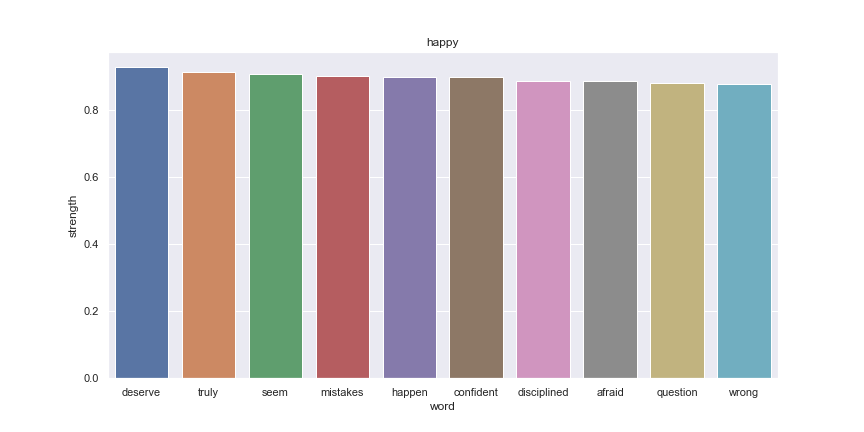

In [417]:
corr_word = input("Your word:")
corr_word = corr_word.lower()
if corr_word not in list(model1.wv.vocab):
    print("Oops looks like that word isn't in our vocabulary yet :/")
else: 
    display_similar_words(corr_word)

### Compare Similarities

On given a word compare the word with multiple 

In [332]:
def compare_sims(w,w1,w2):
    if w not in model1.wv.vocab or w1 not in model1.wv.vocab or w2 not in model1.wv.vocab:
        print("Oops looks like one of the words isn't in our vocabulary :/")
    score1= model1.wv.similarity(w, w1)
    score2= model1.wv.similarity(w, w2)
    print(score1,score2)

In [333]:
corr_word = input("Your word:")
cat1= input("Category 1:")
cat2 = input("Category 2:")
compare_sims(corr_word,cat1,cat2)

Your word:health
Category 1:mental
Category 2:exercise
0.985381 0.46973193


### Score wise :
 * How long are the top most posts?
 * How many of them have bodies?
 * How many of them link to an external resource?
 

In [75]:
df_score = df.sort_values(by=['score'], ascending =False)
print(df_score.head())

          id body  self   orig   score          author  \
2000  85nzj1        0.0  False  144086        SoDakZak   
7155     NaN        0.0  False  144082         Unknown   
7156     NaN        0.0  False  123981         Unknown   
2001  agch5s        0.0  False  123980  OMGLMAOWTF_com   
7157     NaN        0.0  False  112616         Unknown   

                                          title    time subreddit_name  \
2000                image people ’ make excuses  2018-3   GetMotivated   
7155                image people ’ make excuses     NaN   GetMotivated   
7156  image jonah hill stuff used make insecure     NaN   GetMotivated   
2001  image jonah hill stuff used make insecure  2019-1   GetMotivated   
7157                          image slow steady     NaN   GetMotivated   

      body_length  title_length category  
2000          0.0           7.0      NaN  
7155          0.0          27.0      NaN  
7156          0.0          41.0      NaN  
2001          0.0          12.0   

In [342]:
df_score= df_score.drop(columns='orig')

In [343]:
df_score.corr()['score']

self           -0.395365
score           1.000000
body_length    -0.150105
title_length   -0.102507
Name: score, dtype: float64

<IPython.core.display.Javascript object>


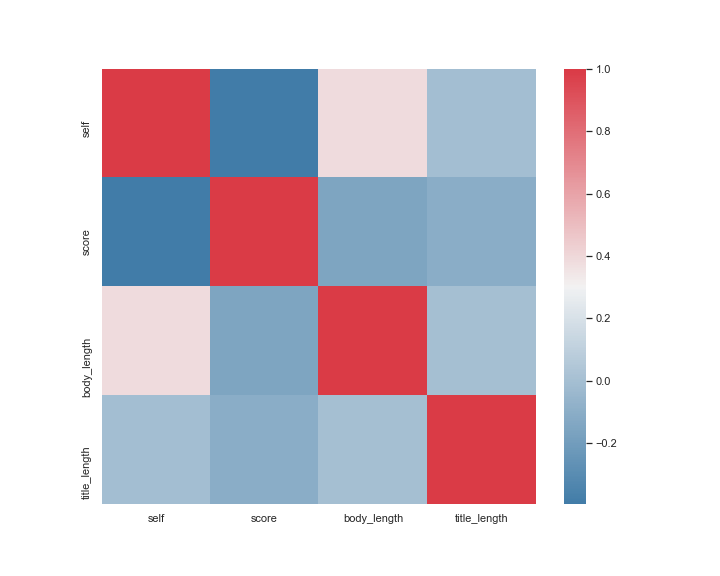

In [344]:
f, ax = plt.subplots(figsize=(10, 8))
corr = df_score.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(240,10,as_cmap=True),
            square=True, ax=ax)

Distribution of scores by subreddit:

Figure out how the comments are distributed on score:

* Based on the distribution it makes sense to split subreddit wise graphs on 0-20000 amd 20000+

<IPython.core.display.Javascript object>


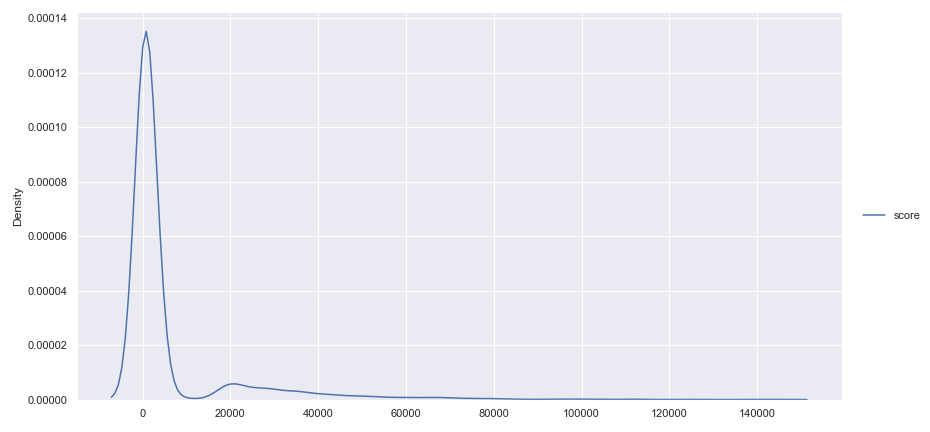

In [403]:
sns.set_theme(style="darkgrid")
ax = sns.displot(pd.DataFrame(df_score["score"]),height=6, aspect=2,kind="kde")

Dropdown(description='Subreddit:', options=('GetMotivated', 'DecidingToBeBetter', 'howtonotgiveafuck', 'getdis…

<IPython.core.display.Javascript object>


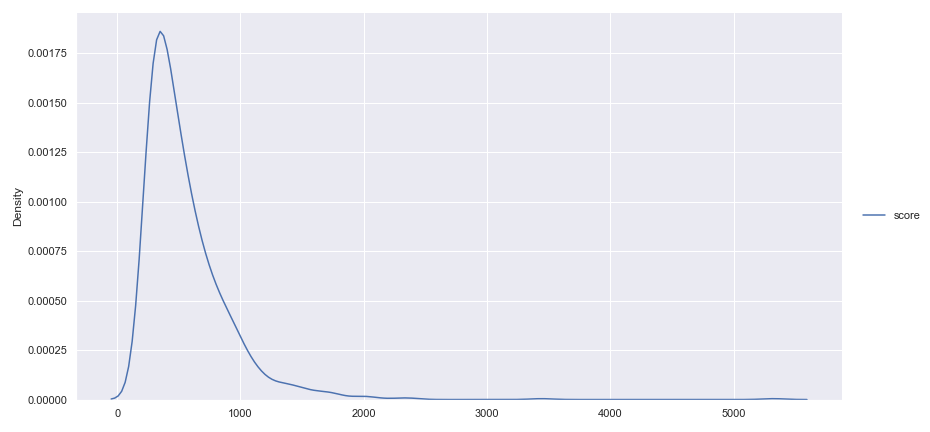

In [402]:
w = widgets.Dropdown(
    options=list(df_score['subreddit_name'].unique()),
    description='Subreddit:',
    disabled=False,
)

def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        sub_red = change['new']
        sns.set_theme(style="darkgrid")
        ax = sns.displot(pd.DataFrame(df_score[(df_score.subreddit_name == sub_red)]["score"]),height=6, aspect=2,kind="kde")


w.observe(on_change)

display(w)

## Score distribution as a product of subreddits for a range of scores

IntSlider(value=0, continuous_update=False, description='Scores Going up till:', max=144086, style=SliderStyle…

<IPython.core.display.Javascript object>


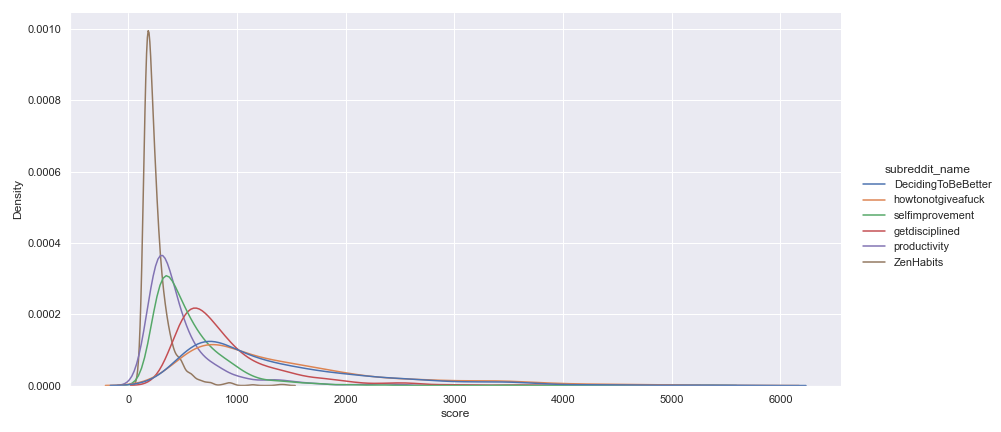

In [418]:
style = {'description_width': 'initial','widget_width':'initial'}
w = widgets.IntSlider(
    value=0,
    min=0,
    max=max(df_score['score']),
    step=1,
    description='Scores Going up till:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    style=style
)


def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        max_score = change['new']
        data = df_score[(df_score.score<=max_score)]
        sns.set_theme(style="darkgrid")
        ax = sns.displot(data = data, x= "score",height=6, aspect=2,hue="subreddit_name",kind="kde")


w.observe(on_change)

display(w)
